# Train Caption-en model

Goal: Extract data information from caption labels

1. Classify opening and closing parentheses and others

2. Classify letters that appear in Month description and digits

Note: We include 't' as a possible letter to avoid confusion due to 'through' 


In [51]:
import os
import sys
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
from keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.externals import joblib

In [52]:
proj_root = os.path.abspath(os.path.join('../')) 
datadir = os.path.join(proj_root, 'data/caption/')
modeldir = os.path.join(proj_root, 'models/')
arcdir = os.path.join(proj_root, 'models/archive')

if not os.path.isdir(datadir): 
    print('data directory not found', os.path.abspath(datadir))
    raise
if not os.path.isdir(modeldir): os.path.makedirs(modeldir)
if not os.path.isdir(modeldir): os.path.makedirs(arcdir)

In [53]:
module_path = os.path.join(proj_root, 'kgschart')
sys.path.append(module_path)
from utils import pad_image

In [54]:
X = np.load(os.path.join(datadir, 'X-en.npy'))
Y = np.load(os.path.join(datadir, 'Y-en.npy'))

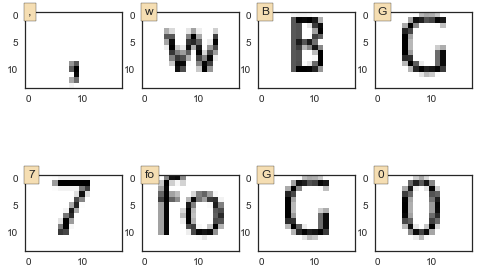

In [55]:
# convenient functions
def random_plot(X, Y, predicted=None):
    if len(Y) < 1: return
    sns.set_style('white')
    indices = np.random.choice(len(Y), min(8, len(Y)))
    count = 0
    for i in indices:
        count += 1
        ax = plt.subplot(2, 4, count)
        ax.imshow(X[i], cmap='gray')
        text = Y[i] if predicted is None else 'tr: %s, pr: %s' % (Y[i], predicted[i])
        ax.text(0, 0, text, bbox={'facecolor':"wheat"})
    plt.show(block=False)

random_plot(X, Y)


def compare_plot(X1, X2):
    sns.set_style('white')
    indices = range(3) if len(X1) <= 3 else np.random.choice(len(X1), 3)
    count = 0
    for i in indices:
        count += 1
        plt.subplot(3, 2, count)
        plt.imshow(X1[i], cmap='gray')
        count += 1
        plt.subplot(3, 2, count)
        plt.imshow(X2[i], cmap='gray')
    plt.show(block=False)

def generate_augmented_data(X, Y, target_size, seed=None):
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, 
                                 data_format='channels_last', channel_shift_range=0.5)
    out_X = None
    out_Y = None
    for x,y in datagen.flow(np.expand_dims(X, axis=4), Y, seed=seed):
        if out_X is None:
            out_X = x
            out_Y = y
        else:
            out_X = np.vstack([out_X, x])
            out_Y = np.concatenate([out_Y, y])
        if len(out_Y) >= target_size: 
            break
    out_X = out_X.squeeze()
    return out_X, out_Y


def diagnosis(fit, X, Y):
    print('accuracy = ', fit.score(X, Y))
    pred = fit.predict(X)
    wrong = (Y != pred)
    if np.any(wrong):
        random_plot(X[wrong], Y[wrong], pred[wrong])
    #print(classification_report(Y, pred))
    print(pd.crosstab(pd.Series(Y), pd.Series(pred), margins=True))

def ngram(x, n):
    out = set()
    for i in range(len(x)-n+1):
        item = x[i:(i+n)]
        if type(x) == str:
            out.add(item)
        else:
            out.add(tuple(item))
    return out 


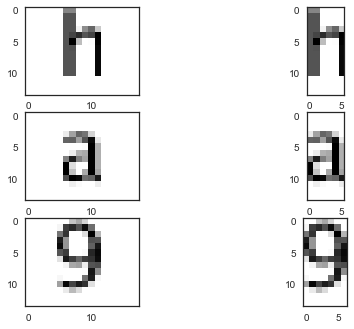

In [56]:
# remove background
def remove_background(x, bg = 1.0, rows=False, cols=True):
    """
    from a image array of size (nrow, ncol),
    remove all rows and cols where values are all bg
    """
    not_bg = (x != bg)
    non_bg_rows = np.any(not_bg, axis=1)
    non_bg_cols = np.any(not_bg, axis=0)
    
    if rows:
        tmp = non_bg_rows.nonzero()[0]
        if len(tmp) == 0: return None
        i1 = tmp[0]
        i2 = tmp[-1] + 1
    else:
        i1 = 0
        i2 = x.shape[0]
    
    if cols:
        tmp = non_bg_cols.nonzero()[0]
        if len(tmp) == 0: return None
        j1 = tmp[0]
        j2 = tmp[-1] + 1
    else:
        j1 = 0
        j2 = x.shape[1]
        
    return x[i1:i2, j1:j2]

X_nobg = [remove_background(x, rows=False) for x in X]
compare_plot(X, X_nobg)

## Train parentheses classifier

In [57]:
# obtain size of parenthesis images

max_rows = 0
max_cols = 0

for i in range(len(Y)):
    if re.search('[\(\)]', Y[i]) is not None:
        max_rows = max(X_nobg[i].shape[0], max_rows)
        max_cols = max(X_nobg[i].shape[1], max_cols)
print(max_rows, max_cols)

target_shape = (max_rows+4, max_cols+4)
print('target_shape', target_shape)

14 12
target_shape (18, 16)


total: 62, included: 62, out: 0
non-included samples
included samples


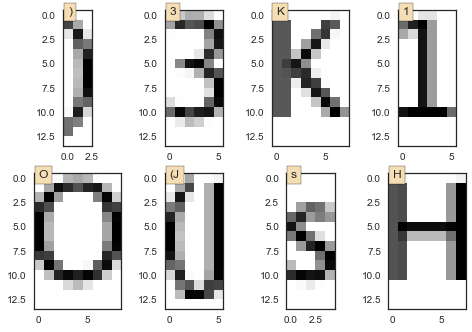

In [58]:
X_out = []
Y_out = []
X_in = []
Y_in = []
for i in range(len(Y)):
    #print(i, X_nobg[i].shape)
    if X_nobg[i].shape[0] <= target_shape[0] and X_nobg[i].shape[1] <= target_shape[1]:
        X_in.append(X_nobg[i])
        Y_in.append(Y[i])
    else:
        X_out.append(X_nobg[i])
        Y_out.append(Y[i])
print('total: %d, included: %d, out: %d' % (len(Y), len(Y_in), len(Y_out)))

print('non-included samples')
random_plot(X_out, Y_out)

print('included samples')
random_plot(X_in, Y_in)

X1 = X_in
Y1 = Y_in

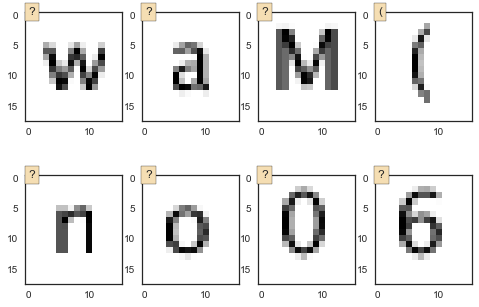

?    57
(     4
)     1
dtype: int64

In [59]:
X1 = [pad_image(x, target_shape[0], target_shape[1], 1.0) for x in X1]
X1 = [np.expand_dims(x, axis=0) for x in X1]
X1 = np.vstack(X1)

for i in range(len(Y1)):
    if Y1[i].find('(') >= 0:
        Y1[i] = '('
    elif Y1[i].find(')') >= 0:
        Y1[i] = ')'
    else:
        Y1[i] = '?'
Y1 = np.array(Y1)

random_plot(X1, Y1)
pd.Series(Y1).value_counts()

In [60]:
# generate test data from image data generator
X_test, Y_test = generate_augmented_data(X1, Y1, 10000, seed = 8)

# generate train data too
X_train, Y_train = generate_augmented_data(X1, Y1, 5000, seed = 7)

In [61]:
# used for data preprocess
class Flatten:
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.reshape(X.shape[0], -1)
    def get_params(self, deep=True):
        return {}


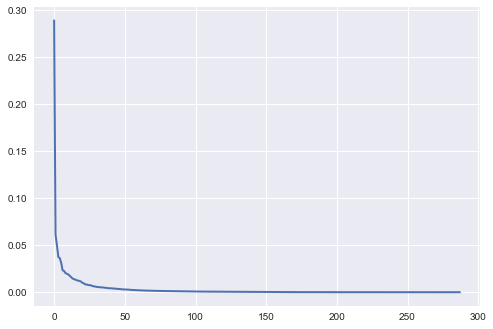

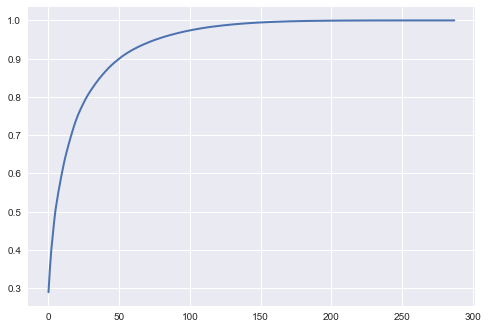

1 0.289295390593
2 0.350665133813
3 0.400488388838
4 0.437829113314
5 0.474102920584
6 0.50551446731
7 0.52882012244
8 0.551435486385
9 0.571849487507
10 0.591473726554
11 0.610432773589
12 0.627957135189
13 0.644085718831
14 0.658722009529
15 0.672634585569
16 0.686096022953
17 0.698774033368
18 0.711039863782
19 0.723073763034
20 0.734369753254
21 0.744399632096
22 0.753790994648
23 0.762166249906
24 0.770398579789
25 0.778041418846
26 0.785548379063
27 0.792938292654
28 0.799526432531
29 0.805795368109
30 0.811764143719
31 0.817478769642
32 0.822985131533
33 0.828301998316
34 0.833512557566
35 0.8385612841
36 0.843548487364
37 0.848271466797
38 0.852890038077
39 0.857191762941
40 0.861462304189
41 0.865658962299
42 0.869677634064
43 0.873626141633
44 0.877429797136
45 0.880991235748
46 0.884418525559
47 0.887709175635
48 0.890962046484
49 0.894059015608
50 0.897031915759
51 0.899941886791
52 0.902810403593
53 0.905617531384
54 0.90834720901
55 0.910858079472
56 0.913271605651
57 0.9

In [62]:
pipe_pca = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', PCA())
])

pipe_pca.fit(X_train)
sns.set()
plt.plot(pipe_pca.named_steps['PCA'].explained_variance_ratio_, linewidth=2)
plt.show(block=False)

cum = pipe_pca.named_steps['PCA'].explained_variance_ratio_.cumsum()
plt.plot(cum, linewidth=2)
plt.show(block=False)
for i in range(len(cum)):
    print(i+1, cum[i])


100 to 150

accuracy on original set =  1.0
accuracy =  0.994307968844


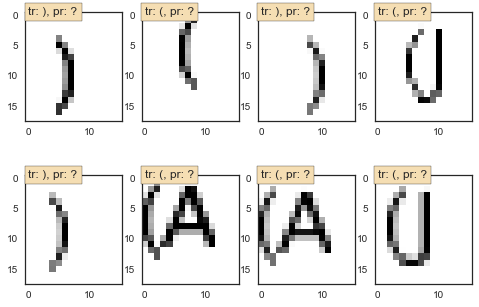

col_0    (    )     ?    All
row_0                       
(      610    0    37    647
)        1  144    16    161
?        2    1  9203   9206
All    613  145  9256  10014


In [63]:
pipe_mlp = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', PCA(n_components=100)),
    ('MLP', MLPClassifier((100,100,100), alpha=0.01))
])    

pipe_mlp.fit(X_train, Y_train)


print('accuracy on original set = ', pipe_mlp.score(X1, Y1))
diagnosis(pipe_mlp, X_test, Y_test)

In [64]:
np.random.seed(87)

# create data prep pipeline and
# fit pca before learning
# this way, we can fix the features to pass to MLP
# if we use incrementalPCA and fit online, then the MLP learning would 
# mess up since there is no guarantee that PCA component i now is the 
# same as the component i in the next fitted PCA
pca = PCA(n_components=100)
pipe_prep = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', pca)
])
pipe_prep.fit(X_train)

model = MLPClassifier((100,100,100), alpha=0.01, warm_start=True)
#model = MLPClassifier((100,100), alpha=0.001, warm_start=True)
pipe_pred = Pipeline([
    ('prep', pipe_prep),
    ('MLP', model)
])

classes = pipe_mlp.classes_

train_gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, 
                               data_format='channels_last', channel_shift_range=0.1)

num = 0
result = None
counter = 0
consec_ones = 0
#for X_batch,Y_batch in train_gen.flow(np.expand_dims(X_in, axis=4), 
#                                      Y_in, batch_size=1000):
while counter <= 5000: 
    X_batch,Y_batch = generate_augmented_data(X1, Y1, 1000)
    counter += 1
    if counter > 5000: break
        
    model.partial_fit(pipe_prep.transform(X_batch.squeeze()), 
                      Y_batch, classes)
    num += len(Y_batch)
    
    score_test     = pipe_pred.score(X_test, Y_test)
    score_original = pipe_pred.score(X1, Y1)
    tmp = dict(size = [num], score_test = [score_test], 
               score_original = [score_original])
    tmp = pd.DataFrame(tmp)
    if result is None:
        result = tmp
    else:
        result = result.append(tmp)
    
    if counter % 100 == 1:
        print(num, 'score on test =', score_test,
              'score on original =', score_original)
    if score_test == 1.0 and score_original == 1.0:
        consec_ones += 1
    if consec_ones >= 10:
        print('DONE!')
        break

1024 score on test = 0.88855602157 score on original = 0.91935483871
103424 score on test = 0.996704613541 score on original = 1.0
205824 score on test = 0.999700419413 score on original = 1.0
308224 score on test = 0.999800279609 score on original = 1.0
DONE!


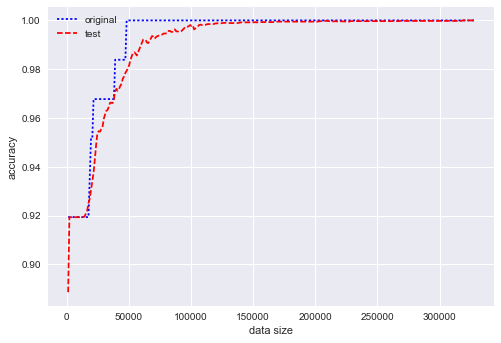

In [65]:
sns.set()
plt.plot(result['size'], result['score_original'], 'b:', label='original')
plt.plot(result['size'], result['score_test'], 'r--', label='test') 
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('data size')
plt.show(block=False)

In [66]:
savename = os.path.join(modeldir, 'caption-en-paren_pca-mlp-full.pkl')
pipe = Pipeline([('PCA', pca), ('MLP', model)])
joblib.dump(pipe, savename)

['C:\\Users\\Kota.Mori\\Documents\\_dev\\kgschart\\models/caption-en-paren_pca-mlp-full.pkl']

In [67]:
with open(os.path.join(modeldir, 'caption-en-paren-config.json'), 'w') as file:
    json.dump(dict(input_shape=X1.shape[1:]), file)

## Classification of date-relevant letters

In [68]:
# obtain size of date relevant images images

max_rows = 0
max_cols = 0

for i in range(len(Y)):
    if re.search('[JanFebMarAprMayJunJulIAugSepOctNovDec0-9\(\),t]', Y[i]) is not None:
        max_rows = max(X_nobg[i].shape[0], max_rows)
        max_cols = max(X_nobg[i].shape[1], max_cols)
print(max_rows, max_cols)

target_shape = (max_rows+4, max_cols+4)
print('target_shape', target_shape)

14 14
target_shape (18, 18)


total: 62, included: 62, out: 0
non-included samples
included samples


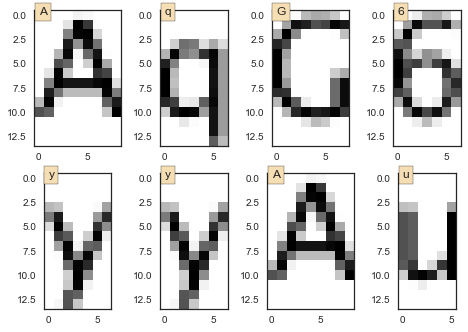

In [69]:
X_out = []
Y_out = []
X_in = []
Y_in = []
for i in range(len(Y)):
    #print(i, X_nobg[i].shape)
    if X_nobg[i].shape[0] <= target_shape[0] and X_nobg[i].shape[1] <= target_shape[1]:
        X_in.append(X_nobg[i])
        Y_in.append(Y[i])
    else:
        X_out.append(X_nobg[i])
        Y_out.append(Y[i])
print('total: %d, included: %d, out: %d' % (len(Y), len(Y_in), len(Y_out)))

print('non-included samples')
random_plot(X_out, Y_out)

print('included samples')
random_plot(X_in, Y_in)

X2 = X_in
Y2 = Y_in

n, a, J, F, b, e, r, a, M, r, p, A, y, a, M, n, u, J, l, u, J, I, u, J, g, A, u, p, S, e, t, c, O, o, v, N, e, D, c, an, Ja, Fe, eb, Ma, ar, pr, Ap, Ma, ay, un, Ju, ul, Ju, uI, Ju, Au, ug, Se, ep, Oc, ct, No, ov, ec, De, (J, (F, (M, (A, (M, (J, (J, (J, (A, (S, (O, (N, (D, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, (, ), ,, t, th


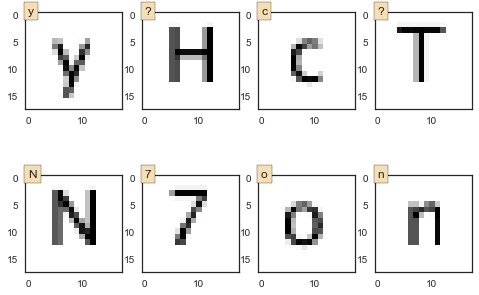

?     23
(J     2
6      1
e      1
,      1
M      1
5      1
F      1
)      1
a      1
ov     1
t      1
(A     1
I      1
N      1
8      1
9      1
v      1
0      1
7      1
u      1
J      1
r      1
4      1
S      1
p      1
o      1
2      1
O      1
(      1
D      1
n      1
3      1
g      1
1      1
b      1
y      1
c      1
A      1
dtype: int64

In [70]:
X2 = [pad_image(x, target_shape[0], target_shape[1], 1.0) for x in X2]
X2 = [np.expand_dims(x, axis=0) for x in X2]
X2 = np.vstack(X2)


month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'JuI', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

month1 = sum([list(ngram(x, 1)) for x in month_names], [])
month2 = sum([list(ngram(x, 2)) for x in month_names], [])
month3 = ['(' + x[0] for x in month_names]
dig_sym = [s for s in '0123456789(),']

date_relevant = month1 + month2 + month3 + dig_sym + ['t', 'th']
print(', '.join(date_relevant))

Y2 = [y if y in date_relevant else '?' for y in Y2]
Y2 = np.array(Y2)

random_plot(X2, Y2)
pd.Series(Y2).value_counts()

In [71]:
# generate test data from image data generator
X_test, Y_test = generate_augmented_data(X2, Y2, 10000, seed = 8)

# generate train data too
X_train, Y_train = generate_augmented_data(X2, Y2, 5000, seed = 7)

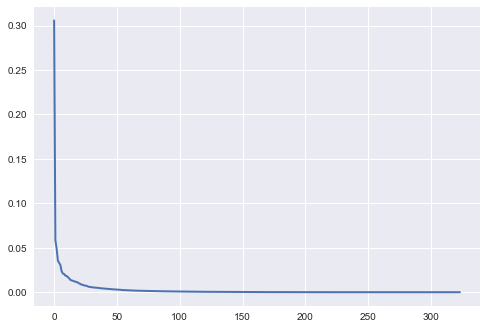

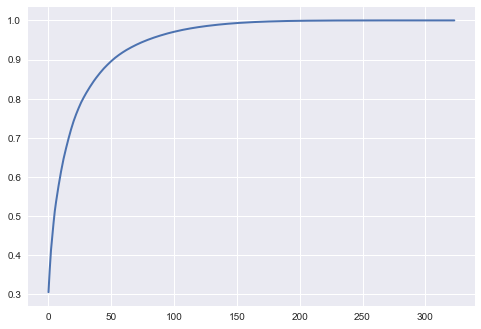

1 0.305826705517
2 0.364277873628
3 0.41336910507
4 0.448829077361
5 0.481908724448
6 0.512483624288
7 0.536002158642
8 0.556889262824
9 0.577340439653
10 0.595916248206
11 0.614224337267
12 0.631005863744
13 0.646647797768
14 0.660459414376
15 0.673728914494
16 0.686581753145
17 0.698844696602
18 0.710698021635
19 0.722093669825
20 0.732881188953
21 0.742700102204
22 0.751944394095
23 0.760345473315
24 0.768598045579
25 0.776121187718
26 0.783550429444
27 0.790641406642
28 0.796986146209
29 0.802995556188
30 0.808951177134
31 0.81450384853
32 0.819902533105
33 0.825133962181
34 0.830271149918
35 0.835246864411
36 0.840171385665
37 0.844779896662
38 0.84928241422
39 0.853601544113
40 0.857786630606
41 0.861913530682
42 0.865877390148
43 0.869713812246
44 0.873468061537
45 0.877092608737
46 0.880486553405
47 0.883753900403
48 0.886954525671
49 0.890087814299
50 0.893173332849
51 0.896082502142
52 0.898957018207
53 0.901764239736
54 0.904398245661
55 0.906912594329
56 0.909307295016
57 0

In [72]:
pipe_pca = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', PCA())
])

pipe_pca.fit(X_train)
sns.set()
plt.plot(pipe_pca.named_steps['PCA'].explained_variance_ratio_, linewidth=2)
plt.show(block=False)

cum = pipe_pca.named_steps['PCA'].explained_variance_ratio_.cumsum()
plt.plot(cum, linewidth=2)
plt.show(block=False)
for i in range(len(cum)):
    print(i+1, cum[i])


accuracy on original set =  1.0
accuracy =  0.964050329539


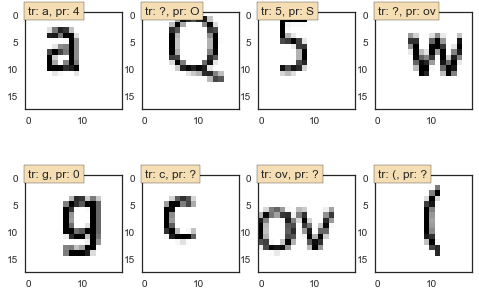

col_0    (   (A   (J    )    ,    0    1    2    3    4  ...      n    o   ov  \
row_0                                                    ...                    
(      157    0    0    0    0    0    0    0    0    0  ...      0    0    0   
(A       0  159    0    0    0    0    0    0    0    1  ...      0    0    1   
(J       0    0  323    0    0    0    0    0    0    0  ...      0    0    0   
)        0    0    0  157    0    0    0    0    0    0  ...      0    0    0   
,        0    0    0    0  158    0    0    0    0    0  ...      0    0    0   
0        0    0    1    0    0  153    0    0    0    0  ...      0    0    0   
1        0    0    0    0    0    0  158    0    3    0  ...      0    0    0   
2        0    0    0    0    0    0    0  159    0    0  ...      0    0    0   
3        0    0    0    0    0    0    1    3  151    0  ...      0    0    0   
4        0    0    0    0    0    0    0    0    0  156  ...      0    0    0   
5        0    0    0    0   

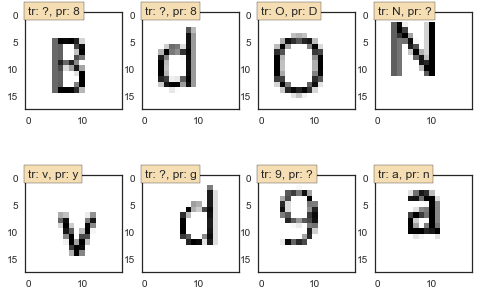

col_0    (   (A   (J    )    ,    0    1    2    3    4  ...      n    o   ov  \
row_0                                                    ...                    
(      157    0    0    0    0    0    0    0    0    0  ...      0    0    0   
(A       0  159    0    0    0    0    0    0    0    1  ...      0    0    1   
(J       0    0  323    0    0    0    0    0    0    0  ...      0    0    0   
)        0    0    0  157    0    0    0    0    0    0  ...      0    0    0   
,        0    0    0    0  158    0    0    0    0    0  ...      0    0    0   
0        0    0    1    0    0  153    0    0    0    0  ...      0    0    0   
1        0    0    0    0    0    0  158    0    3    0  ...      0    0    0   
2        0    0    0    0    0    0    0  159    0    0  ...      0    0    0   
3        0    0    0    0    0    0    1    3  151    0  ...      0    0    0   
4        0    0    0    0    0    0    0    0    0  156  ...      0    0    0   
5        0    0    0    0   

In [73]:
pipe_mlp = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', PCA(n_components=100)),
    ('MLP', MLPClassifier((100,100,100), alpha=0.01))
])    

pipe_mlp.fit(X_train, Y_train)


print('accuracy on original set = ', pipe_mlp.score(X2, Y2))
diagnosis(pipe_mlp, X_test, Y_test)
diagnosis(pipe_mlp, X_test, Y_test)

In [74]:
np.random.seed(87)

# create data prep pipeline and
# fit pca before learning
# this way, we can fix the features to pass to MLP
# if we use incrementalPCA and fit online, then the MLP learning would 
# mess up since there is no guarantee that PCA component i now is the 
# same as the component i in the next fitted PCA
pca = PCA(n_components=100)
pipe_prep = Pipeline([
    ('flatten', Flatten()), 
    ('PCA', pca)
])
pipe_prep.fit(X_train)

#model = MLPClassifier((100,100,100), alpha=0.001, warm_start=True)
model = MLPClassifier((100,100), alpha=0.001, warm_start=True)
pipe_pred = Pipeline([
    ('prep', pipe_prep),
    ('MLP', model)
])

classes = pipe_mlp.classes_


num = 0
result = None
counter = 0
consec_ones = 0
#for X_batch,Y_batch in train_gen.flow(np.expand_dims(X_in, axis=4), 
#                                      Y_in, batch_size=1000):
while counter <= 5000: 
    X_batch,Y_batch = generate_augmented_data(X2, Y2, 1000)
    counter += 1
    if counter > 5000: break
        
    model.partial_fit(pipe_prep.transform(X_batch.squeeze()), 
                      Y_batch, classes)
    num += len(Y_batch)
    
    score_test     = pipe_pred.score(X_test, Y_test)
    score_original = pipe_pred.score(X2, Y2)
    tmp = dict(size = [num], score_test = [score_test], 
               score_original = [score_original])
    tmp = pd.DataFrame(tmp)
    if result is None:
        result = tmp
    else:
        result = result.append(tmp)
    
    if counter % 100 == 1:
        print(num, 'score on test =', score_test,
              'score on original =', score_original)
    if score_test == 1.0 and score_original == 1.0:
        consec_ones += 1
    if consec_ones >= 10:
        print('DONE!')
        break

1024 score on test = 0.330936688636 score on original = 0.338709677419
103424 score on test = 0.918713800679 score on original = 1.0
205824 score on test = 0.988615937687 score on original = 1.0
308224 score on test = 0.995706011584 score on original = 1.0
410624 score on test = 0.999800279609 score on original = 1.0
513024 score on test = 0.999900139804 score on original = 1.0
DONE!


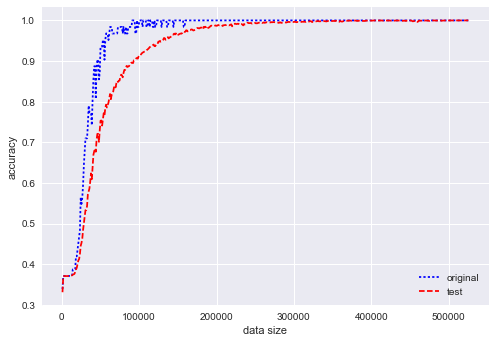

In [75]:
sns.set()
plt.plot(result['size'], result['score_original'], 'b:', label='original')
plt.plot(result['size'], result['score_test'], 'r--', label='test') 
plt.legend()
plt.ylabel('accuracy')
plt.xlabel('data size')
plt.show(block=False)

In [76]:
savename = os.path.join(modeldir, 'caption-en-letter_pca-mlp-full.pkl')
pipe = Pipeline([('PCA', pca), ('MLP', model)])
joblib.dump(pipe, savename)

['C:\\Users\\Kota.Mori\\Documents\\_dev\\kgschart\\models/caption-en-letter_pca-mlp-full.pkl']

In [77]:
with open(os.path.join(modeldir, 'caption-en-letter-config.json'), 'w') as file:
    json.dump(dict(input_shape=X2.shape[1:]), file)